In [24]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
import math
from sklearn.preprocessing import StandardScaler
from scipy.stats import truncnorm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns

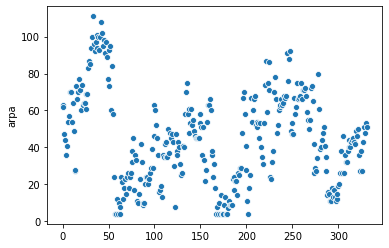

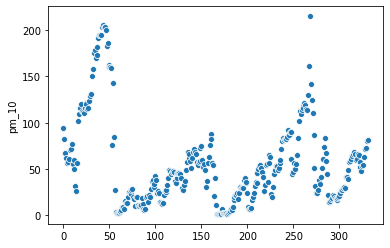

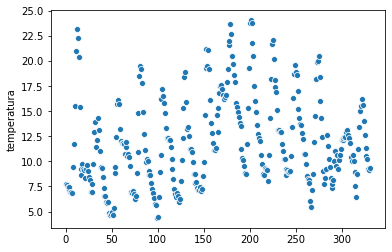

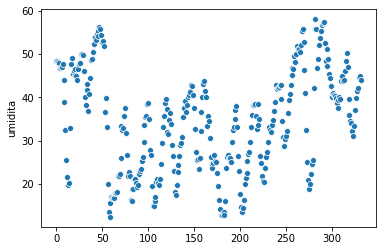

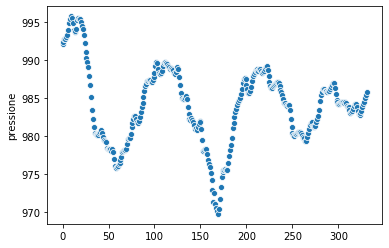

In [25]:
ds = pd.read_csv('ciao.csv', sep=";")
sns.scatterplot(np.arange(len(ds['arpa'])), ds['arpa'])
plt.figure()
sns.scatterplot(np.arange(len(ds['pm_10'])), ds['pm_10'])
plt.figure()
sns.scatterplot(np.arange(len(ds['temperatura'])), ds['temperatura'])
plt.figure()
sns.scatterplot(np.arange(len(ds['umidita'])), ds['umidita'])
plt.figure()
sns.scatterplot(np.arange(len(ds['pressione'])), ds['pressione'])

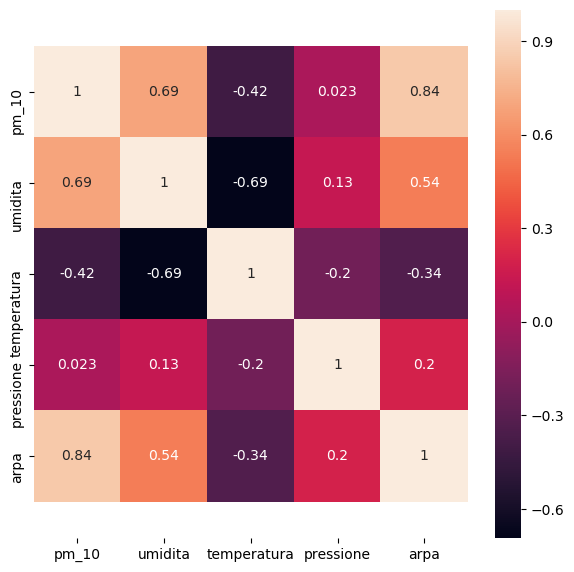

In [26]:
corr = ds.corr(method='pearson')
plt.figure(figsize=(7,7), dpi=100)
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ris = ax.set_ylim(bottom + 0.4, top - 0.4)

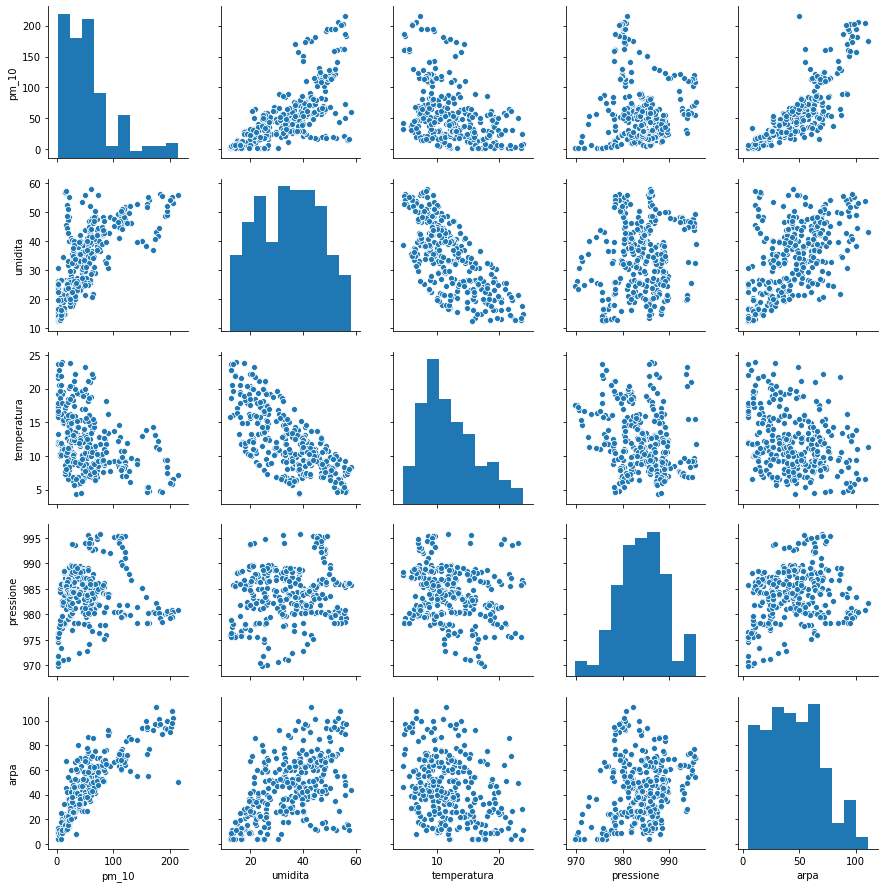

In [27]:
sns.pairplot(ds)

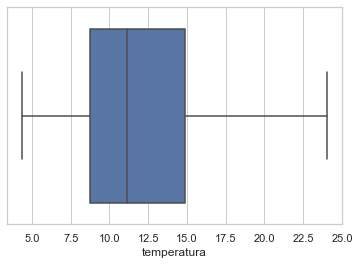

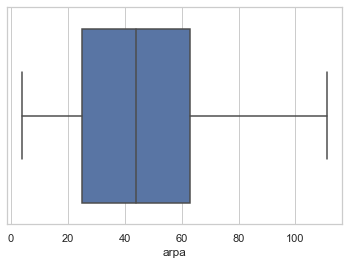

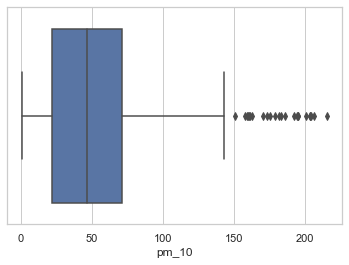

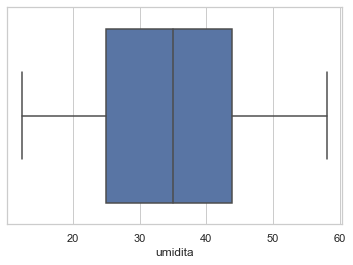

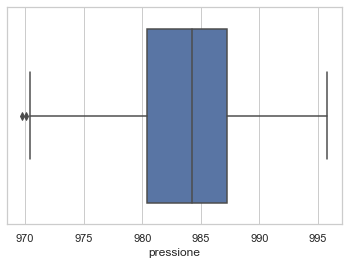

In [28]:
sns.set(style="whitegrid")
sns.boxplot(ds['temperatura'])
plt.figure()
sns.boxplot(ds['arpa'])
plt.figure()
sns.boxplot(ds['pm_10'])
plt.figure()
sns.boxplot(ds['umidita'])
plt.figure()
sns.boxplot(ds['pressione'])

In [29]:
def gradient_method(A, b, rip, x0):
    x = np.zeros(A.shape[1])
    xk = x0
    rk = b - np.dot(A, xk)
    for i in range(rip):
        zk = np.dot(A, rk)
        alpha = np.dot(rk.T, rk)/(np.dot(rk.T, zk))
        xk = xk + alpha * rk
        rk = rk - alpha * zk
    return xk      

In [30]:
def conjugate_gradient_method(A, b, rip, x0):
    xk = x0
    rk = b - np.dot(A, xk)
    dk = rk
    for i in range(rip):
        zk = np.dot(A, dk)
        alpha = np.dot(rk.T, dk)/np.dot(dk.T, zk)
        xk = xk + alpha*dk
        rk_old = rk
        rk = rk - alpha*zk
        beta = - np.dot(rk.T, rk)/np.dot(rk_old.T, rk_old)
        dk = rk + beta*dk
    return xk

In [31]:
def least_sqare_method(x, y):
    numeroColonne = x.shape[1]
    numeroRighe = x.shape[0]
    vetty = np.dot(y, x).reshape(numeroColonne, 1)

    pa = np.array(np.zeros(numeroColonne ** 2)).reshape(numeroColonne, numeroColonne)

    for i in range(numeroColonne):
        for j in range(numeroColonne):
            for k in range(numeroRighe):
                pa[i][j] += x[k][i] * x[k][j]

    return conjugate_gradient_method(pa, vetty, 10000, np.array([1,1,1,1]).reshape(4,1))

0.7766833168842204


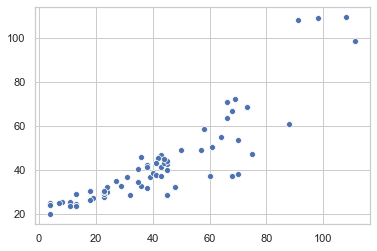

In [32]:
u = np.array(ds.drop(['arpa'], axis = 1))
uns = u.copy()
y = np.array(ds['arpa'])
for i in range(u.shape[1]):
    scaler = StandardScaler()
    u[:, i] = scaler.fit_transform(u[:, i].reshape(-1, 1)).reshape(332,)

X_train, X_test, y_train, y_test = train_test_split(uns, y, test_size=0.2, random_state=42)
ris = least_sqare_method(X_train, y_train)
y_1 = np.dot(X_test, ris)
y_pred = y_1
print(r2_score(y_test,y_pred))
sns.scatterplot(y_test, y_pred.reshape(1, len(y_pred))[0])

In [33]:
n = len(u)
H = 50
I = 4
shape_w = (I,H) 
shape_x = (H,) 

#a = [u[:,i].max() for i in range(u.shape[1])]
#b = [u[:,i].min() for i in range(u.shape[1])]

#for i in range(n):
 #   for j in range(I):
  #      u[i, j] = (u[i, j] - a[j])/(b[j]-a[j])


#print(u)


In [34]:
class NeuralNetwork():
    
    def __init__(self, shape_w, shape_x, learning_rate):
        self.shape_w = shape_w
        self.shape_x = shape_x
        self.w = np.random.uniform(0,0.1,(shape_w[0], shape_w[1]))
        self.x = np.random.uniform(0,0.1,(shape_x[0]))
        self.b = 0.5
        self.H = shape_w[1]
        self.I = shape_w[0]
        self.vb =  np.random.uniform(0,0.1,H)
        self.learning_rate = learning_rate
        

    def sigmoid(self, x):
        return scipy.special.expit(x)
    
    def ReLU(self,x):
        return x * (x > 0)

    def train(self, training_inputs, training_outputs, training_iterations,tol, verbose = False):
        m = 1
        mu = self.learning_rate
        SSEold = 10000
        
        for iteration in range(training_iterations):
            v_star = np.dot(training_inputs, self.w)
           # v_star += self.vb
  
            v = self.sigmoid(v_star+self.vb)
            output = self.b + np.dot(v, self.x)
            output_error = training_outputs-output
            
            #mu *= 0.9999
            
            self.b += mu*output_error.sum()
            hidden_deltas = np.zeros((training_inputs.shape[0], self.H))
             #compute hidden deltas 
            for h in range(self.H):
                for p in range(training_inputs.shape[0]):
                    hidden_deltas[p, h]=output_error[p]*self.x[h]

            
            for i in range(self.I):
                for h in range(self.H):
                    for p in range(training_inputs.shape[0]):
                        self.w[i,h] += mu*output_error[p]*self.x[h]*v[p,h]*(1-v[p,h])*training_inputs[p,i]
            
            for h in range (self.H):
                change=0;
                for p in range(training_inputs.shape[0]):
                    change=change+hidden_deltas[p][h];
                    
                self.vb[h]=self.vb[h]+(change*self.learning_rate);
       
            
            
            appo = np.dot(v.T, output_error)
            self.x += mu * appo
                
            SSEnew = ((output_error)**2).sum()
            if verbose == 1:
                print(m, SSEnew)
            if abs(SSEnew-SSEold) < tol:
                return 
            else:
                if(math.isnan(SSEnew)):
                    return
            SSEold = SSEnew
                
            m+=1

    def think(self, inputs):
        v_star = np.dot(inputs, self.w)
        v = self.sigmoid(v_star)
        output = np.dot(v, self.x) + self.b
        return output
    
    def save_model(self, path_file):
        with open(path_file, 'w') as file:
            file.write(str(neural_network.w).replace("\n", " ").replace("]", " ").replace("[", " ")+"\n")
            file.write(str(neural_network.x).replace("\n", " ").replace("]", " ").replace("[", " ")+"\n")
            file.write(str(neural_network.b).replace("\n", " ").replace("]", " ").replace("[", " ")+"\n")
    
    def load_model(self, path_file):
        with open(path_file, 'r') as file:
            filecontents = file.readlines()
            appo = list(str(filecontents[0]).split(" "))
            appo.remove("\n")
            vett = [val for val in appo  if val != '' ]
            self.w = np.array(vett, dtype = float).reshape(self.shape_w)
            appo = list(str(filecontents[1]).split(" "))
            appo.remove("\n")
            vett = [val for val in appo if val != '' ]
            self.x = np.array(vett, dtype = float).reshape(self.shape_x)
            self.b = float(filecontents[2])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(u, y, test_size=0.2, random_state=42)
shape_w = (I,H) 
shape_x = (H,) 

neural_network = NeuralNetwork(shape_w, shape_x, 0.0001)


neural_network.train(X_train, y_train, 400, 1e-2, verbose = 1)

print("Synaptic weights after training: ")
print(neural_network.w)
print(neural_network.x)
print(neural_network.b)
print(neural_network.vb)

1 675844.9791363562
2 344093.9901328656
3 161495.62503842416
4 116140.963096789
5 103116.87256729968
6 93704.98966305912
7 86779.83723054247
8 81440.76957837632
9 77132.89023654988
10 73499.11841839695
11 70317.9246958663
12 67454.50467256823
13 64828.72772775679
14 62394.37953576473
15 60125.9209212752
16 58010.02714457005
17 56040.14865004252
18 54213.01018690955
19 52526.39296050471
20 50977.79690714246
21 49563.72140240311
22 48279.37962377524
23 47118.705701759376
24 46074.54336800801
25 45138.929290955515
26 44303.406814110895
27 43559.32636038432
28 42898.10632556531
29 42311.44205734536
30 41791.460331317154
31 41330.82298343714
32 40922.786750719315
33 40561.22770189479
34 40240.63862547401
35 39956.106953804876
36 39703.27964715586
37 39478.32020949022
38 39277.86181639708
39 39098.95948753245
40 38939.04336244068
41 38795.87444091548
42 38667.503611765525
43 38552.23439419092
44 38448.5895292732
45 38355.281361873625
46 38271.1858248102
47 38195.31976014019
48 38126.82127262

375 36714.43517748959
376 36713.368389773044
377 36712.31164886629
378 36711.264925031624
379 36710.22818885761
380 36709.201411258764
381 36708.18456347492
382 36707.17761707079
383 36706.18054393538
384 36705.19331628142
385 36704.21590664472
386 36703.24828788356
387 36702.29043317793
388 36701.34231602882
389 36700.403910257504
390 36699.475190004574
391 36698.556129729164
392 36697.64670420802
393 36696.746888534384
394 36695.85665811713
395 36694.97598867949
396 36694.10485625794
397 36693.243237200906
398 36692.39110816749
399 36691.548446125984
400 36690.71522835244
Synaptic weights after training: 
[[ 1.27969784e+00  1.58175828e+00  1.45341643e+00  1.57019515e+00
   1.75179390e+00  1.66225537e+00  1.33377831e+00  1.31071933e+00
   1.86373175e+00  1.35840191e+00  1.30869802e+00  1.79436260e+00
   1.67416022e+00  1.41803038e+00  1.74301212e+00  1.43166675e+00
   1.78943046e+00  1.68653843e+00  1.45619361e+00  1.49182158e+00
   1.73076568e+00  1.51306939e+00  1.20717998e+00  1.81

0.8295118528686207


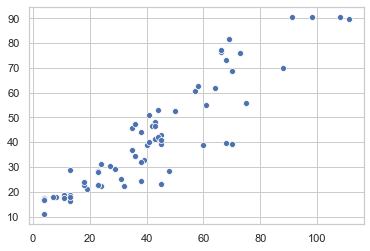

In [36]:
y_pred = neural_network.think(X_test)
print(r2_score(y_test,y_pred))
sns.scatterplot(y_test, y_pred)

0.8375239177911094


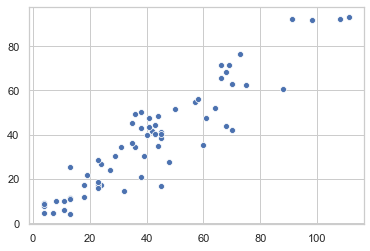

In [37]:
poly = PolynomialFeatures(3)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)
shape_w = (len(X_train2[0]),H) 
shape_x = (H,) 

neural_network = NeuralNetwork(shape_w, shape_x, 0.0001)
neural_network.train(X_train2, y_train, 100, 1e-1)
y_pred = neural_network.think(X_test2)
print(r2_score(y_test,y_pred))
sns.scatterplot(y_test, y_pred)

In [38]:
y = [3.769677 ,7.885598 ,7.756317,8.136820 ,6.276089 ,8.058394 ,5.382590 ,8.196260 ,6.964032 ,6.762684]
u  = np.array([0.000783,0.153779 ,0.560532 ,0.865013 ,0.276724 ,0.895919 ,0.704462 ,0.886472 ,0.929641 ,0.469290 ,0.350208 ,0.941637 ,0.096535 ,0.457211 ,0.346164 ,0.970019 ,0.114938 ,0.769819 ,0.341565,0.684224 ]).reshape(10,2)
n = len(u)
H = 8
I = 2
a = [u[:,0].max(), u[:,1].max()]
b = [u[:,0].min(), u[:,1].min()]
for i in range(n):
    for j in range(I):
        u[i, j] = (u[i, j] - a[j])/(b[j]-a[j])

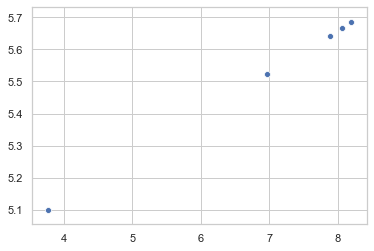

In [39]:
X_train, X_test, y_train, y_test = train_test_split(u, y, test_size=0.5, random_state=42)
shape_w = (2,8) 
shape_x = (8,) 

neural_network = NeuralNetwork(shape_w, shape_x,  0.0001)


neural_network.train(X_train, y_train, 20000, 1e-12)

y_pred = neural_network.think(X_test)
sns.scatterplot(y_test, y_pred)